<a href="https://colab.research.google.com/github/yrodriguezmd/IceVision_miniprojects/blob/main/01_object_detection_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installations, Imports and Loading



In [ ]:
# gpu, high ram
#icevision.__version__
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [ ]:
from icevision.all import *
import icedata

path = icedata.pets.load_data()

#### Quick Exploration and Establish Paths

In [ ]:
path.ls()

In [ ]:
Path('/root/.icevision/data/pets/annotations').ls()

(#7) [Path('/root/.icevision/data/pets/annotations/test.txt'),Path('/root/.icevision/data/pets/annotations/trimaps'),Path('/root/.icevision/data/pets/annotations/trainval.txt'),Path('/root/.icevision/data/pets/annotations/list.txt'),Path('/root/.icevision/data/pets/annotations/xmls'),Path('/root/.icevision/data/pets/annotations/._trimaps'),Path('/root/.icevision/data/pets/annotations/README')]

In [ ]:
import pandas as pd
df = pd.read_csv(Path('/root/.icevision/data/pets/annotations/trainval.txt'))
df.head()

Abyssinian_100 1 1 1
0  Abyssinian_101 1 1 1
1  Abyssinian_102 1 1 1
2  Abyssinian_103 1 1 1
3  Abyssinian_104 1 1 1
4  Abyssinian_105 1 1 1

In [ ]:
df.shape
# 3679 observations

(3679, 1)

In [ ]:
Path('/root/.icevision/data/pets/images').ls()

(#7393) [Path('/root/.icevision/data/pets/images/boxer_107.jpg'),Path('/root/.icevision/data/pets/images/shiba_inu_195.jpg'),Path('/root/.icevision/data/pets/images/great_pyrenees_141.jpg'),Path('/root/.icevision/data/pets/images/Siamese_53.jpg'),Path('/root/.icevision/data/pets/images/wheaten_terrier_51.jpg'),Path('/root/.icevision/data/pets/images/boxer_120.jpg'),Path('/root/.icevision/data/pets/images/german_shorthaired_131.jpg'),Path('/root/.icevision/data/pets/images/yorkshire_terrier_74.jpg'),Path('/root/.icevision/data/pets/images/english_cocker_spaniel_61.jpg'),Path('/root/.icevision/data/pets/images/american_pit_bull_terrier_81.jpg')...]

In [ ]:
# Get the class_map, a utility that maps from number IDs to classs names
class_map = icedata.pets.class_map()

class_map
# background + 36 kinds of pets

<ClassMap: {'background': 0, 'Abyssinian': 1, 'Bengal': 2, 'Birman': 3, 'Bombay': 4, 'British_Shorthair': 5, 'Egyptian_Mau': 6, 'Maine_Coon': 7, 'Persian': 8, 'Ragdoll': 9, 'Russian_Blue': 10, 'Siamese': 11, 'Sphynx': 12, 'american_bulldog': 13, 'american_pit_bull_terrier': 14, 'basset_hound': 15, 'beagle': 16, 'boxer': 17, 'chihuahua': 18, 'english_cocker_spaniel': 19, 'english_setter': 20, 'german_shorthaired': 21, 'great_pyrenees': 22, 'havanese': 23, 'japanese_chin': 24, 'keeshond': 25, 'leonberger': 26, 'miniature_pinscher': 27, 'newfoundland': 28, 'pomeranian': 29, 'pug': 30, 'saint_bernard': 31, 'samoyed': 32, 'scottish_terrier': 33, 'shiba_inu': 34, 'staffordshire_bull_terrier': 35, 'wheaten_terrier': 36, 'yorkshire_terrier': 37}>

#### Parse

  0%|          | 0/3686 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/2948 [00:00<?, ?it/s]

  0%|          | 0/738 [00:00<?, ?it/s]

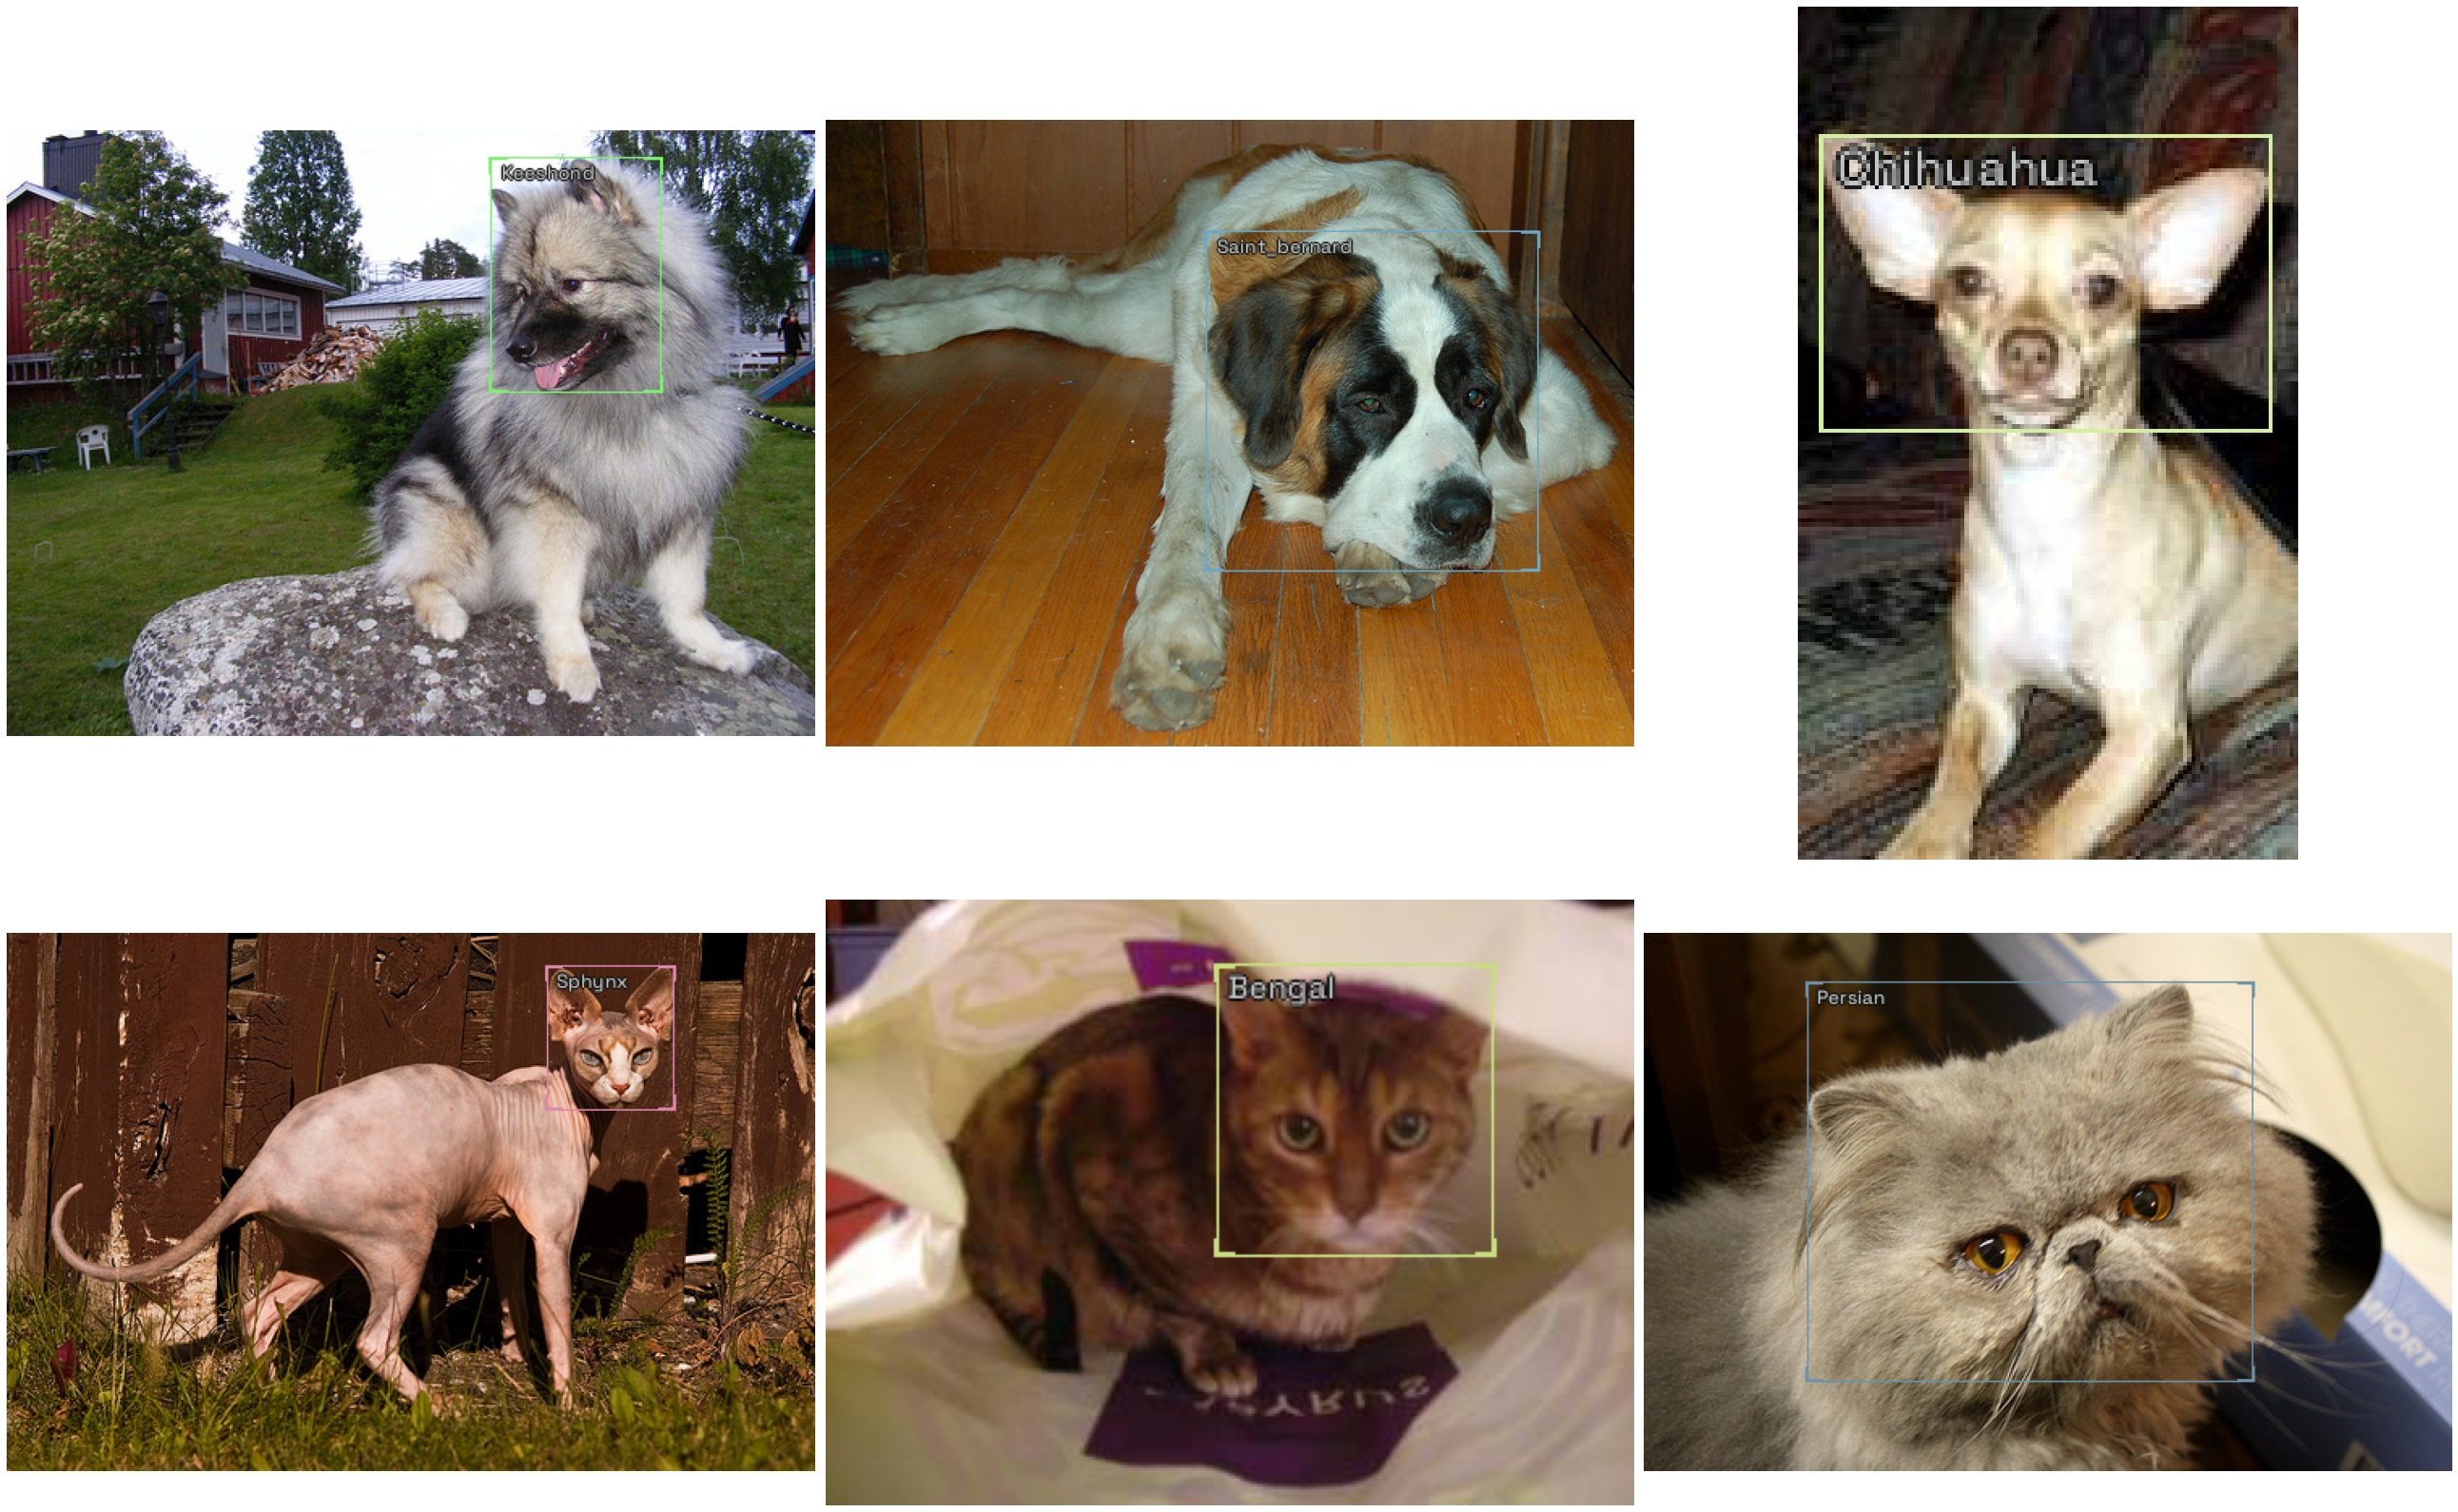

In [ ]:
data_splitter = RandomSplitter([0.8, 0.2])

# PETS parser: provided out-of-the-box

parser = icedata.pets.parser(data_dir=path)## removed map

train_records, valid_records = parser.parse(data_splitter)

show_records(train_records[:6], ncols=3, class_map=class_map, show=True)

#### Transforms, DataSets, DataLoaders

In [ ]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

#### Model

In [ ]:
model_type = models.torchvision.faster_rcnn

model = faster_rcnn.model(num_classes= len(class_map)) ## 
# source: https://github.com/spiyer99/aerial_object_detection/blob/master/icevision_geospatial.ipynb

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=2.0892961401841603e-05)

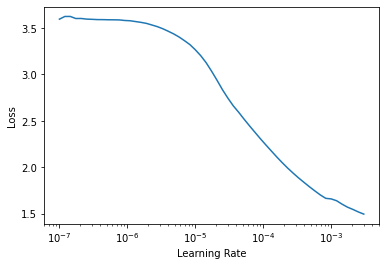

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)
learn.lr_find()

In [ ]:
learn.fine_tune(10, 0.005, freeze_epochs=1)

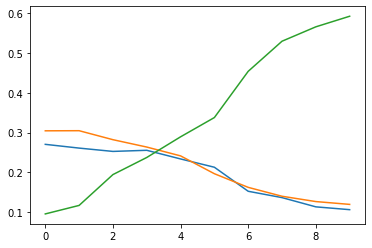

In [ ]:
import matplotlib.pyplot as plt
plt.plot(L(learn.recorder.values).itemgot());
# blue train_loss, orange valid loss, green metric
# should stop at n_epoch=3-4
# x epoch
# y metric

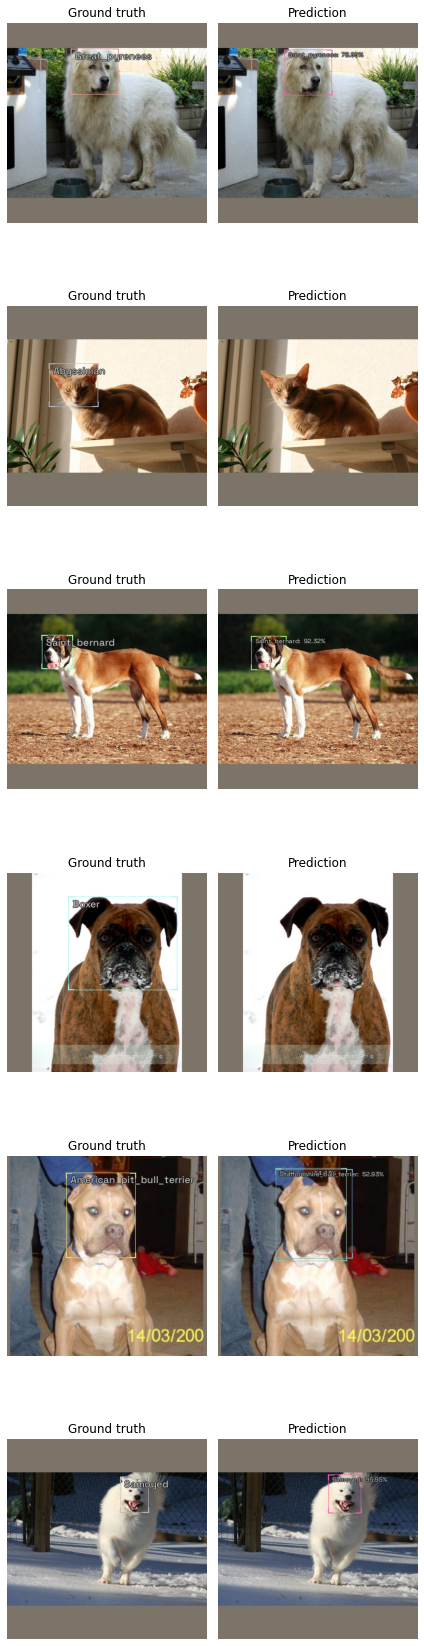

In [ ]:
faster_rcnn.show_results(model, valid_ds)

In [ ]:
!pip install bing-image-downloader
from bing_image_downloader import downloader
query_string = 'cat'
cat_1 = downloader.download(query_string, limit = 1, 
                            output_dir = 'dataset',
                            adult_filter_off=True,
                            force_replace=False,
                            timeout=60,
                            verbose=True)
cat_1

[%] Downloading Images to /content/dataset/cat


[!!]Indexing page: 1

[%] Indexed 1 Images on Page 1.


[%] Downloading Image #1 from https://i.redd.it/lln5boitd7c21.jpg
[%] File Downloaded !



[%] Done. Downloaded 1 images.

Please show your support here
https://www.buymeacoffee.com/gurugaurav




In [ ]:
cat_1_url = ['https://i.redd.it/lln5boitd7c21.jpg']
dest = 'Desktop'
download_url(cat_1_url[0],dest)

from PIL import Image

image = Image.open(dest)
#image.to_thumb(128)

In [ ]:
img = np.array(image)

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

infer = Dataset.from_images([img], infer_tfms, class_map = class_map)

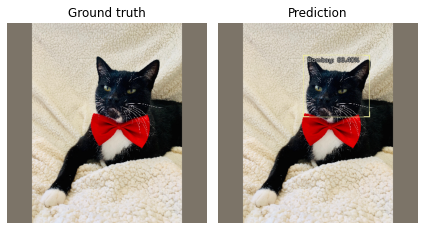

In [ ]:
preds = model_type.predict(model, infer, keep_images=True)

show_preds(preds=preds)

In [ ]:
!pip install bing-image-downloader
from bing_image_downloader import downloader
query_string = 'Persian cat'
cat_1 = downloader.download(query_string, limit = 1, 
                            output_dir = 'dataset',
                            adult_filter_off=True,
                            force_replace=False,
                            timeout=60,
                            verbose=True)
cat_1

[%] Downloading Images to /content/dataset/Persian cat


[!!]Indexing page: 1

[%] Indexed 1 Images on Page 1.


[%] Downloading Image #1 from https://pixfeeds.com/images/cats/1280-633113756-white-persian-cats.jpg
[%] File Downloaded !



[%] Done. Downloaded 1 images.

Please show your support here
https://www.buymeacoffee.com/gurugaurav




In [ ]:
cat_1_url = ['https://pixfeeds.com/images/cats/1280-633113756-white-persian-cats.jpg']
dest = 'Desktop'
download_url(cat_1_url[0],dest)

from PIL import Image

image = Image.open(dest)
#image.to_thumb(128)

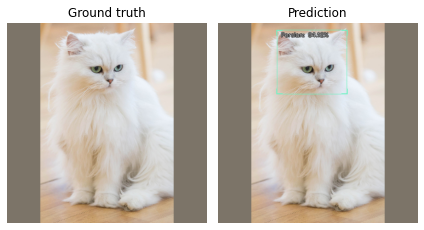

In [ ]:
img = np.array(image)

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

infer = Dataset.from_images([img], infer_tfms, class_map=class_map )#

preds = model_type.predict(model, infer, keep_images=True)

show_preds(preds=preds)
# with bbox but no label

  0%|          | 0/152149505 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/utils/weight_init.py:119: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  'init_cfg without layer key, if you do not define override'


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([333, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([333]).


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=7.585775847473997e-07)

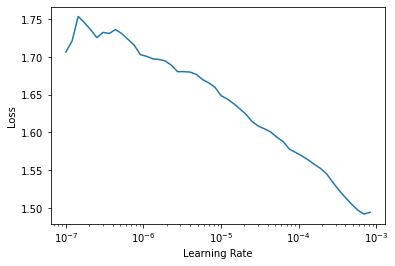

In [ ]:
## trying another model to check train/ valid loss
model_type = models.mmdet.retinanet

backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

learn.lr_find()

In [ ]:
# using mmdet retinanet
learn.fine_tune(10, 0.0003, freeze_epochs=1)
# epoch 4 valid loss slightly higher than train loss, but continues to go down

In [ ]:
# trying more epochs
# using mmdet retinanet
learn.fine_tune(20, 0.0003, freeze_epochs=1)
# epoch 4 valid loss slightly higher than train loss, but continues to go down

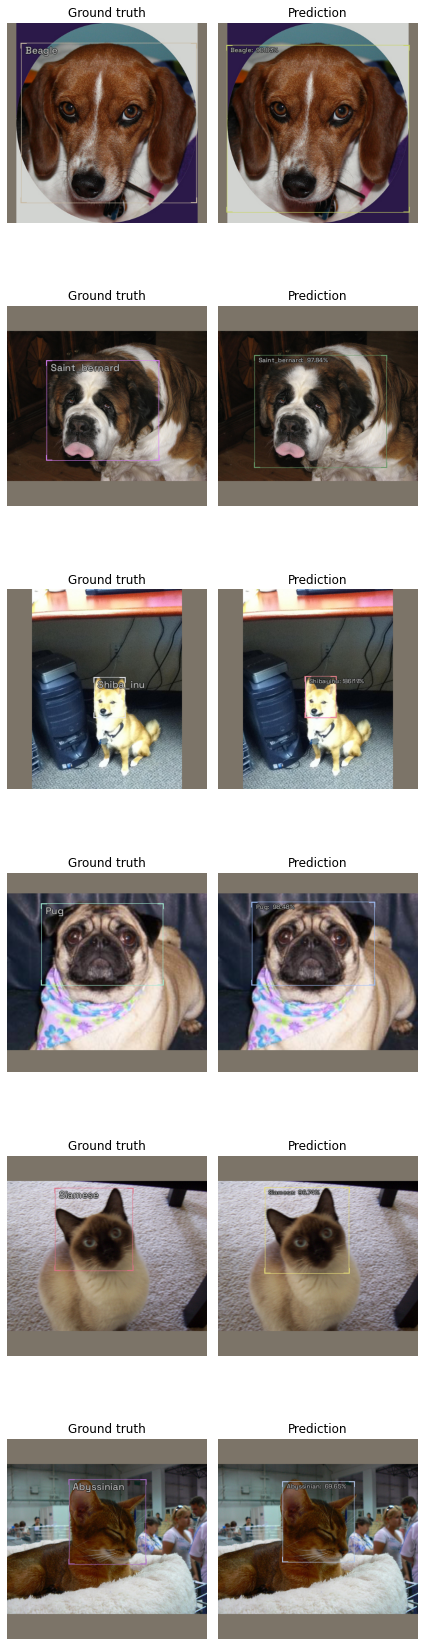

In [ ]:
# epoch 20
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
# limiting to epoch 7
# using mmdet retinanet
learn.fine_tune(7, 0.0003, freeze_epochs=1)
# epoch 4 valid loss slightly higher than train loss, but continues to go down

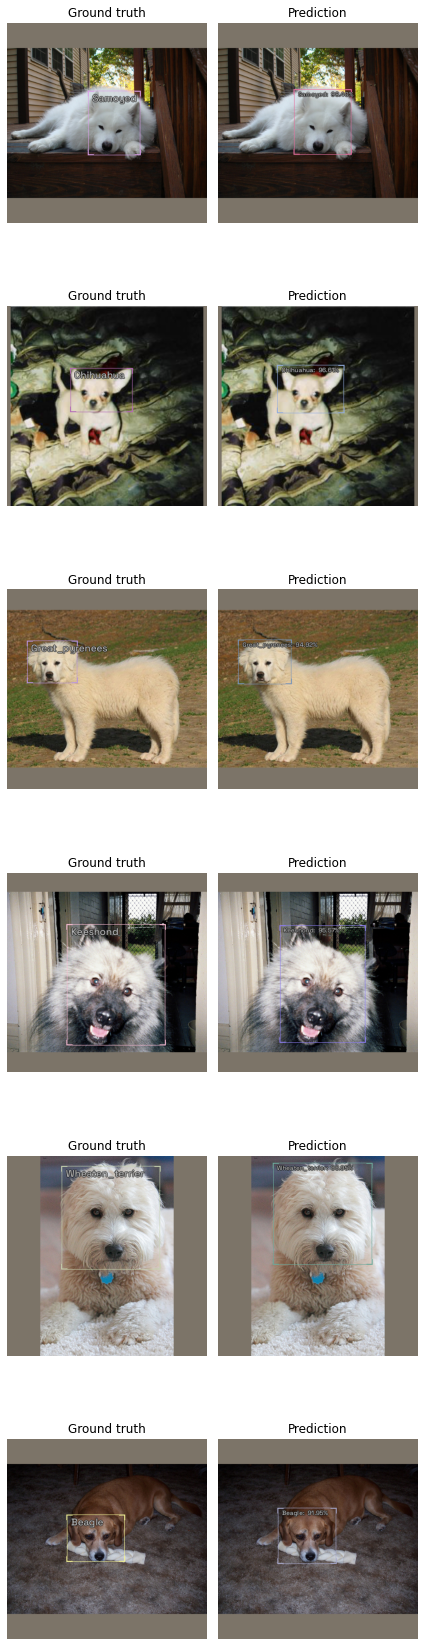

In [ ]:
# epoch 7
model_type.show_results(model, valid_ds, detection_threshold=.5)

No handles with labels found to put in legend.


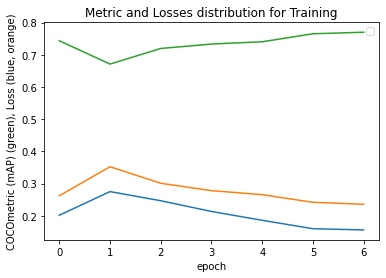

In [ ]:
# n_epoch 7, lr 0.0003, mmdet, retinanet
import matplotlib.pyplot as plt
plt.plot(L(learn.recorder.values).itemgot())
plt.xlabel('epoch')
plt.ylabel('COCOmetric (mAP) (green), Loss (blue, orange)')
plt.title('Metric and Losses distribution for Training')
# blue train_loss, orange valid loss, green metric
# should stop at n_epoch=3-4
# x epoch
# y metric

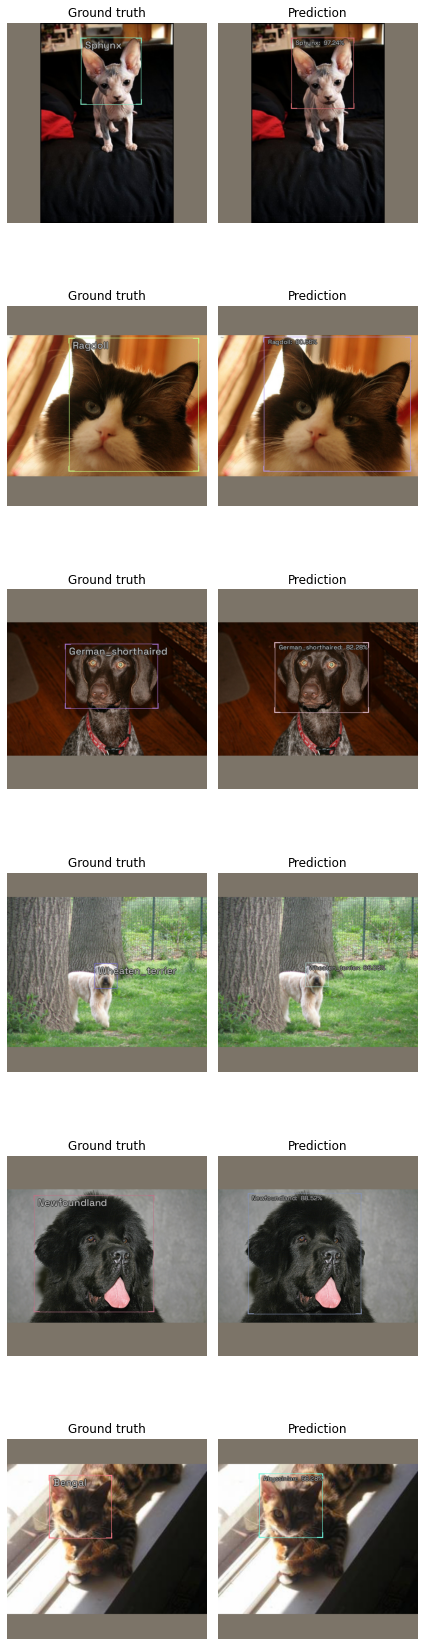

In [ ]:
# using mmdet retinanet
# epoch 10
model_type.show_results(model, valid_ds, detection_threshold=.5)

No handles with labels found to put in legend.


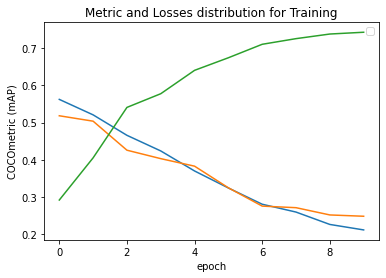

In [ ]:
# n_epoch 10, lr 0.0003, mmdet, retinanet
import matplotlib.pyplot as plt
plt.plot(L(learn.recorder.values).itemgot())
plt.xlabel('epoch')
plt.ylabel('COCOmetric (mAP) (green), Loss (blue, orange)')
plt.title('Metric and Losses distribution for Training')
plt.legend();
# blue train_loss, orange valid loss, green metric
# should stop at n_epoch=3-4
# x epoch
# y metric

In [ ]:
!pip install bing-image-downloader
from bing_image_downloader import downloader
query_string = 'Persian cat'
cat_1 = downloader.download(query_string, limit = 1, 
                            output_dir = 'dataset',
                            adult_filter_off=True,
                            force_replace=False,
                            timeout=60,
                            verbose=True)
cat_1

[%] Downloading Images to /content/dataset/Persian cat


[!!]Indexing page: 1

[%] Indexed 1 Images on Page 1.


[%] Downloading Image #1 from https://pixfeeds.com/images/cats/1280-633113756-white-persian-cats.jpg
[%] File Downloaded !



[%] Done. Downloaded 1 images.

Please show your support here
https://www.buymeacoffee.com/gurugaurav




In [ ]:
cat_1_url = ['https://pixfeeds.com/images/cats/1280-633113756-white-persian-cats.jpg']
dest = 'Desktop'
download_url(cat_1_url[0],dest)

from PIL import Image

image = Image.open(dest)
#image.to_thumb(128)

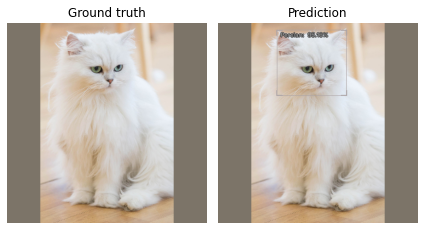

In [ ]:
# using mmdet retinanet
img = np.array(image)

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

infer = Dataset.from_images([img], infer_tfms, class_map=class_map )#

preds = model_type.predict(model, infer, keep_images=True)

show_preds(preds=preds)

In [ ]:
learn_b = learn.fine_tune(4, 0.005, freeze_epochs=1)
learn_b

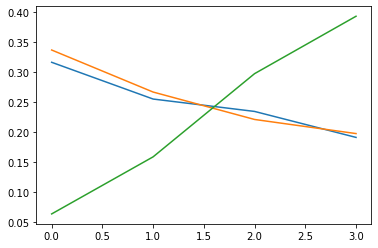

In [ ]:
import matplotlib.pyplot as plt
plt.plot(L(learn.recorder.values).itemgot());
# blue train_loss, orange valid loss, green metric
# should stop at n_epoch=3-4
# x epoch
# y metric

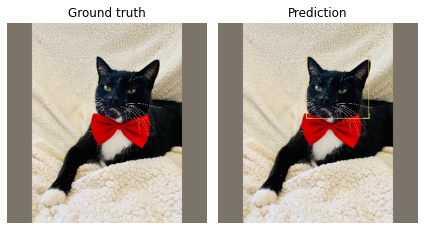

In [ ]:
# when using weights from url
from icedata.utils import load_model_weights_from_url

WEIGHTS_URL = 'https://github.com/airctic/model_zoo/releases/download/m3/pets_faster_resnetfpn50.zip'
load_model_weights_from_url(model, WEIGHTS_URL, map_location=torch.device('cpu'))

preds = model_type.predict(model, infer, keep_images=True)

show_preds(preds=preds)